# Compute the MAP example with the `QuantifAI` model using simulated MeerKAT ungridded visibilities

### Using a simulated "parallel" algorithm: a distributed image-strategy FISTA algorithm with random mini-batches.

In this notebook we:
- set hyperparameters,
- prepare the synthetic observations,
- define the model, likelihood and prior,
- estimate the MAP reconstruction through a convex optimisation algorithm,
- plot the MAP estimation result and the error.



In [1]:
import os
import numpy as np
import time as time

# Import torch and select GPU
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

# Plot functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Radio and convex reg functions
import quantifai as qai
from quantifai.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg

## Set hyperparameters 

In [2]:
# Parameters

# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 100, "record_iters": False}

# Save param
repo_dir = "./.."

# Test image name from ['M31', 'W28', 'CYN', '3c288']
img_name = "M31"
# Input noise level
input_snr = 30.0

# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = "./../trained_models/"
# CRR parameters
lmbd = 1e4  # lambda parameter
mu = 20

## Load visibilities

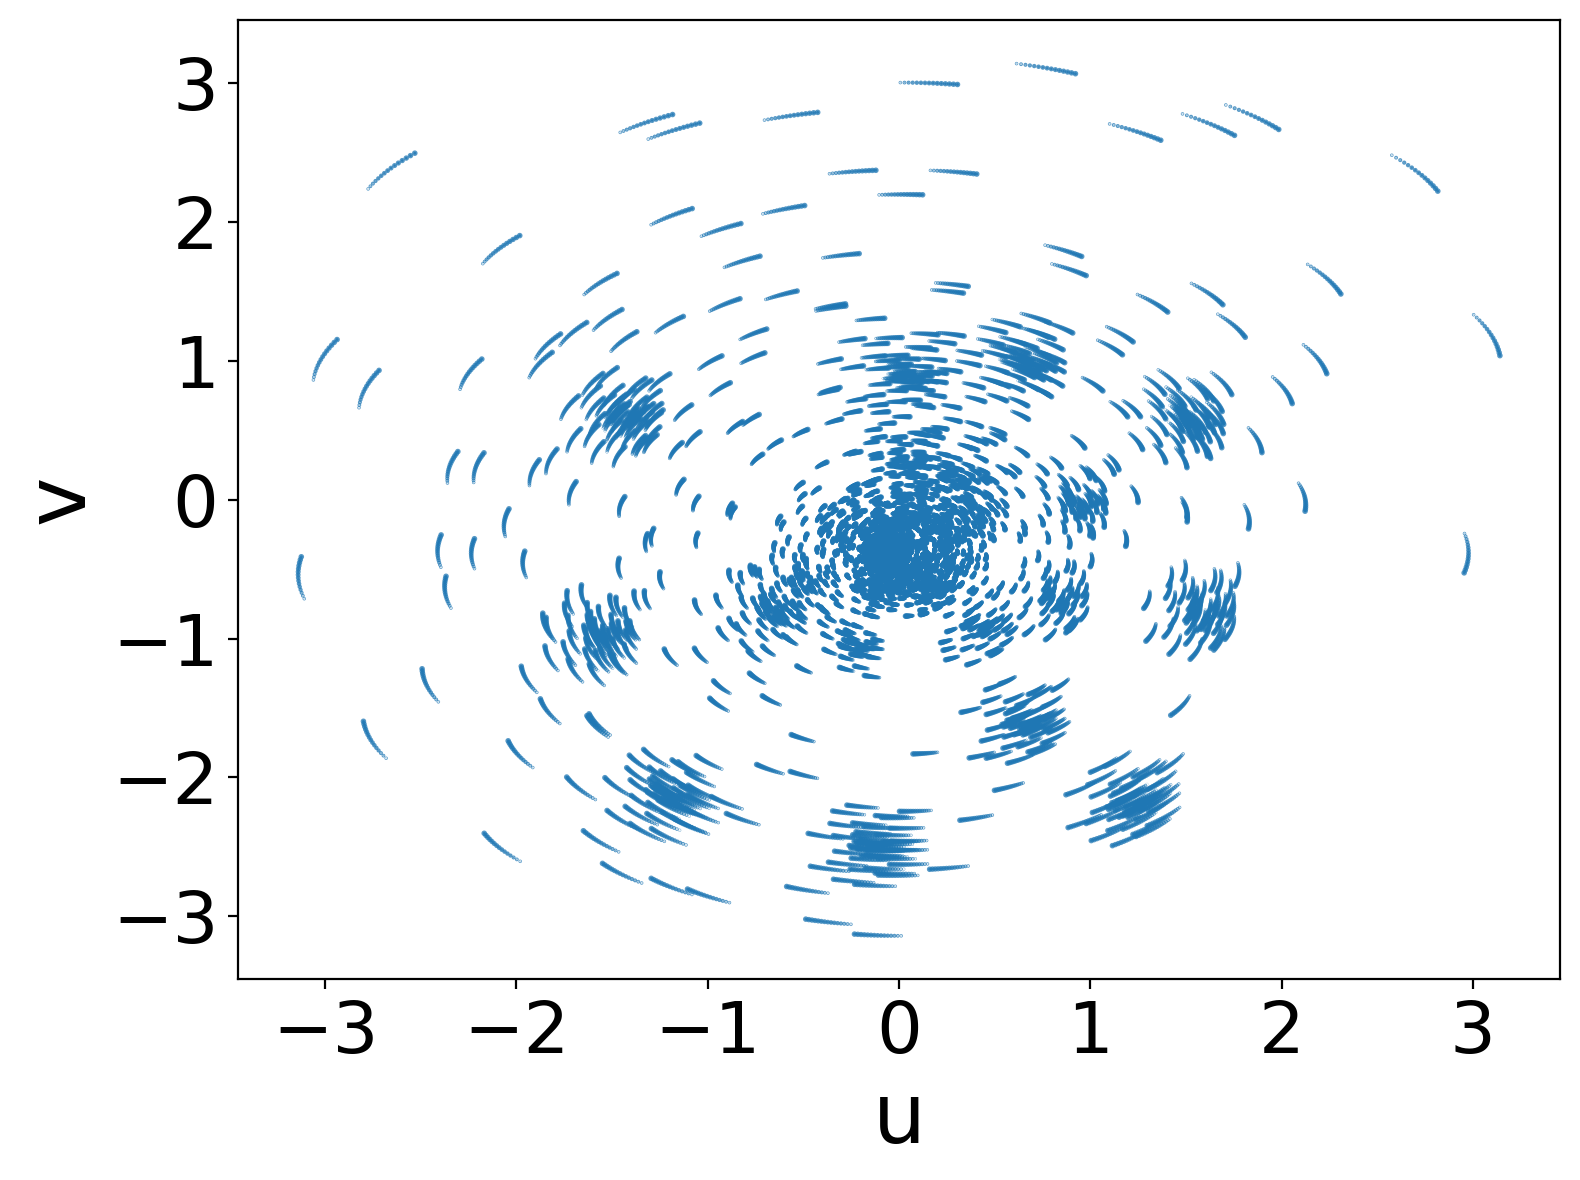

In [3]:
uv_path = repo_dir + "/data/meerkat_ungridded_vis/meerkat_simulation_1h_uv_only.npy"
uv_data = np.load(uv_path, allow_pickle=True)[()]
uv = np.concatenate((uv_data['uu'].reshape(-1,1), uv_data['vv'].reshape(-1,1)), axis=1)


plt.figure(figsize=(8,6), dpi=200)
s = (np.arange(len(uv[:,0])) + 1) / (len(uv[:,0]))
ax = plt.gca()
plt.scatter(uv[:,0], uv[:,1], s=s, alpha=0.75)

plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

plt.xlabel(r"u", fontsize=30)
plt.ylabel(r"v", fontsize=30)
plt.tight_layout()
# plt.savefig(save_dir + "meerkat_" + vis_time + "_uv_coverage.jpg")
plt.show()

# Prepare observations 

### Define NUFFT-based forward operator phi 

In [4]:
# Load image and mask
img, _ = qai.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img


torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape(
    (1,) + img.shape
)


torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape(
    (1,1) + img.shape
)
torch_uv = torch.tensor(uv.T, device=device, dtype=myType)

phi = qai.operators.KbNuFFT2d_torch(
    uv=torch_uv,
    im_shape=img.shape,
    device=device,
    interp_points=6,
    k_oversampling=2,
    myType=myType,
    myComplexType=myComplexType
)


INSTRUME                                                                         [astropy.io.fits.card]
/Users/tl255879/miniconda3/envs/convex_uq_distributed/lib/python3.9/site-packages/torchkbnufft/_nufft/spmat.py:101: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647058851/work/torch/csrc/utils/tensor_new.cpp:653.)
  torch.sparse.FloatTensor(inds, real_vals, torch.Size(shape)),  # type: ignore


In [5]:
torch_uv.shape

torch.Size([2, 30240])

### Generate observations

In [6]:
y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Define noise level
eff_sigma = qai.helpers.compute_complex_sigma_noise(y, input_snr)
sigma = eff_sigma * np.sqrt(2)

# Generate noise
rng = np.random.default_rng(seed=0)
n_re = rng.normal(0, eff_sigma, y[y != 0].shape)
n_im = rng.normal(0, eff_sigma, y[y != 0].shape)
# Add noise
y[y != 0] += n_re + 1.0j * n_im

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType)[None, None, :]

# Generate first guess
x_init = torch.abs(phi.adj_op(torch_y))


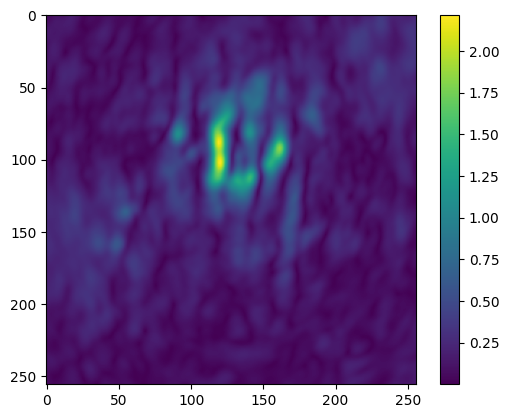

In [7]:
plt.figure()
plt.imshow(x_init[0,0,:,:])
plt.colorbar()
plt.show()

In [8]:
torch_y.shape

torch.Size([1, 1, 30240])

# Define likelihood and prior

In [9]:
# Define the likelihood
likelihood = qai.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
    im_shape=x_init.shape
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
prox_op = qai.operators.RealProx_torch()

In [10]:
# Load CRR model
torch.set_grad_enabled(False)
torch.set_num_threads(4)

exp_name = f"Sigma_{sigma_training}_t_{t_model}/"
if device.type == "cpu":
    CRR_model = utils_cvx_reg.load_model(
        CRR_dir_name + exp_name, "cpu", device_type="cpu"
    )
elif device.type == "cuda":
    CRR_model = utils_cvx_reg.load_model(
        CRR_dir_name + exp_name, "cuda", device_type="gpu"
    )


print(f"Numbers of parameters before prunning: {CRR_model.num_params}")
CRR_model.prune()
print(f"Numbers of parameters after prunning: {CRR_model.num_params}")

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183


/Users/tl255879/miniconda3/envs/convex_uq_distributed/lib/python3.9/site-packages/convex_reg/utils.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

In [11]:
# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
CRR_model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
L_CRR = CRR_model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
# L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")

Lipschitz bound 0.781


# Run "parallel" optimisation algorithm anc compute the MAP reconstruction

Reference: 
- Algorithm 6 Distributed image FISTA with random mini-batches

In [14]:
n_workers = 5
mini_batch_size = 6000

vis_number = torch_y.shape[2]

assert mini_batch_size * n_workers <= vis_number

workers_id_list = np.arange(n_workers)

In [ ]:

# Compute stepsize
alpha = 0.98 / (likelihood.beta + mu * lmbd * L_CRR)


In [ ]:

# Relax the optimisation options (lower number of iterations) to accelerate the test

# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 50, "update_iter": 1, "record_iters": False}


In [17]:
# initialization
x_hat = torch.clone(x_init)
z = torch.clone(x_init)
t = 1

im_shape = x_init.shape

for it in range(options["iter"]):

    x_hat_old = torch.clone(x_hat)

    # Prepare random index list to draw the mini-batchs
    idx_list = np.arange(vis_number)
    np.random.shuffle(idx_list)  # Shuffle the list in-place

    
    # Init the empty list (to simulate mpi parallelisation)
    v_r = [[] for it in range(len(workers_id_list))]

    for worker_id in workers_id_list:

        if worker_id == 0:
            # Compute CRR update
            v_r[worker_id] = alpha * lmbd * CRR_model.grad(mu * z).reshape(im_shape)
        
        else:
            # get index for this worker
            worker_idx_list = idx_list[int((worker_id-1)*mini_batch_size):int(worker_id*mini_batch_size)]
            # get data block 
            mini_batch_y = torch_y[:,:,worker_idx_list]
            # Build the measurement operator
            mini_batch_torch_uv = torch_uv[:,worker_idx_list]
            mini_batch_phi = qai.operators.KbNuFFT2d_torch(
                uv=mini_batch_torch_uv,
                im_shape=img.shape,
                device=device,
                interp_points=6,
                k_oversampling=2,
                myType=myType,
                myComplexType=myComplexType
            )
            # Build the likelihood
            mini_batch_likelihood = qai.operators.L2Norm_torch(
                sigma=sigma,
                data=mini_batch_y,
                Phi=mini_batch_phi,
                im_shape=x_init.shape
            )

            # Compute likelihood update
            v_r[worker_id] = alpha * mini_batch_likelihood.grad(z)

    # Simulate reduce_sum
    # print(np.array(v_r).shape)
    v = torch.from_numpy(np.sum(np.array(v_r), axis=0))
    # Reality constraint. Ref: line 21 in the pseudocode
    v = prox_op.prox(v)
    # Ref: line 22 in the pseudocode
    x_hat = z - v


    t_old = t
    t = 0.5 * (1 + np.sqrt(1 + 4 * t**2))
    z = x_hat + (t_old - 1) / t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat) / torch.norm(x_hat_old)).item()

    if res < options["tol"]:
        print("[GD] converged in %d iterations" % (it))
        break

    if it % options["update_iter"] == 0:
        print(
            "[GD] %d out of %d iterations, tol = %f"
            % (
                it,
                options["iter"],
                res,
            )
        )


[GD] 0 out of 50 iterations, tol = 0.093429
[GD] 1 out of 50 iterations, tol = 0.087625
[GD] 2 out of 50 iterations, tol = 0.108928
[GD] 3 out of 50 iterations, tol = 0.122481
[GD] 4 out of 50 iterations, tol = 0.132534
[GD] 5 out of 50 iterations, tol = 0.132763
[GD] 6 out of 50 iterations, tol = 0.134774
[GD] 7 out of 50 iterations, tol = 0.139126
[GD] 8 out of 50 iterations, tol = 0.137181
[GD] 9 out of 50 iterations, tol = 0.128067
[GD] 10 out of 50 iterations, tol = 0.112339
[GD] 11 out of 50 iterations, tol = 0.092855
[GD] 12 out of 50 iterations, tol = 0.071661
[GD] 13 out of 50 iterations, tol = 0.056048
[GD] 14 out of 50 iterations, tol = 0.046926
[GD] 15 out of 50 iterations, tol = 0.043580
[GD] 16 out of 50 iterations, tol = 0.044693
[GD] 17 out of 50 iterations, tol = 0.046036
[GD] 18 out of 50 iterations, tol = 0.044703
[GD] 19 out of 50 iterations, tol = 0.041713
[GD] 20 out of 50 iterations, tol = 0.037232
[GD] 21 out of 50 iterations, tol = 0.031919
[GD] 22 out of 50 it

# Plot MAP reconstruction

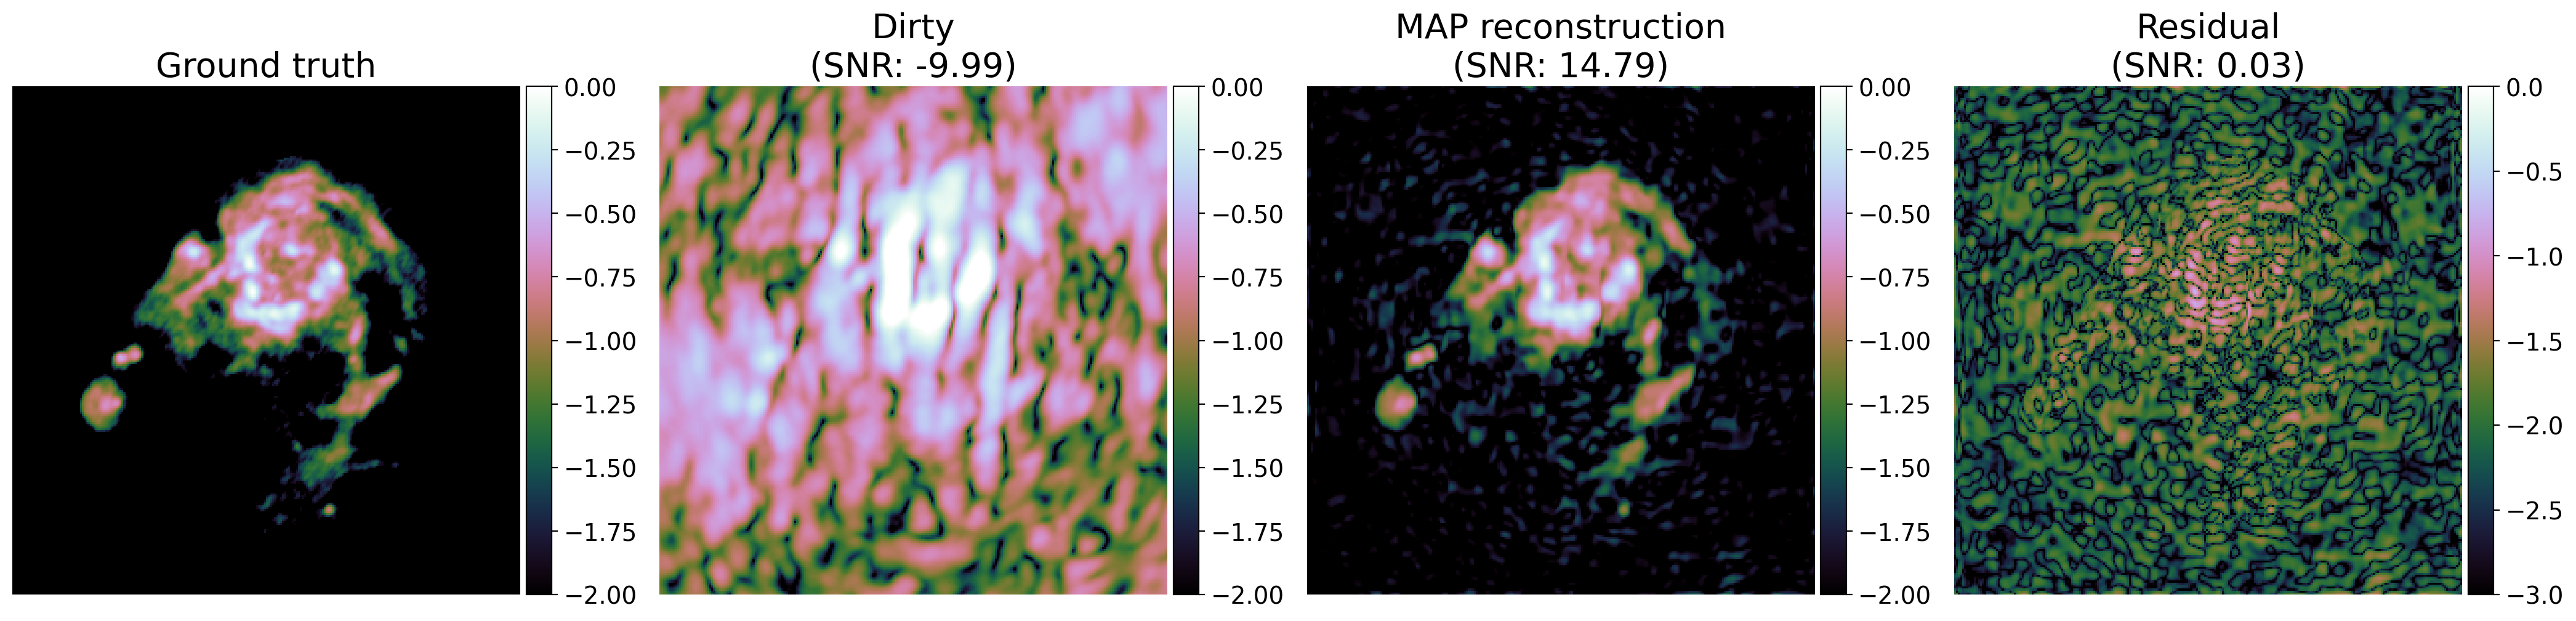

In [18]:
# Convert to numpy
np_x_init = to_numpy(x_init)
x_map = x_hat.clone()
x_gt = np.copy(x)
np_x_gt = np.copy(x)
np_x_map = to_numpy(x_map)


# Need to replace zero values with veery small numbers for the log plots
np_x_gt[np_x_gt == 0] = np.random.rand(np.sum(np_x_gt == 0)) * 1e-7

images = [np_x_gt, np_x_init, np_x_map, np_x_gt - np.abs(np_x_map)]
labels = ["Ground truth", "Dirty", "MAP reconstruction", "Residual"]
vmin_log = [-2.0, -2.0, -2.0, -3.0]

cmap = "cubehelix"

fig, axs = plt.subplots(1, 4, figsize=(26, 8), dpi=200)
for i in range(4):
    im = axs[i].imshow(np.log10(np.abs(images[i])), cmap=cmap, vmax=0, vmin=vmin_log[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=14)
    if i > 0:
        stats_str = "\n(SNR: {})".format(
            round(qai.utils.eval_snr(x, images[i]), 2),
        )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=20)
    axs[i].axis("off")
plt.show()